In [ ]:
import random
import numpy as np
import torch 

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, WeightedRandomSampler
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
from google.colab import drive
#drive.mount('content/drive/My_Drive/Colab_Notebook')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/dataverse_files'

/content/drive/My Drive/Colab Notebooks/dataverse_files


In [ ]:
!ls

HAM10000_images_part_1	HAM10000_images_part_2	HAM10000_metadata  Train.csv


In [ ]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/dataverse_files'

In [ ]:
data_dir = '.'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))


In [ ]:
len(all_image_path)

10015

In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

 Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [ ]:
#### the function bellow normalize the images -> for all datset BUT I DESIDED TO NOT USE IT 

In [ ]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [ ]:
#norm_mean,norm_std = compute_img_mean_std(all_image_path)

 91%|█████████▏| 9161/10015 [1:00:39<17:13,  1.21s/it]

In [ ]:
#norm_mean,norm_std

In [ ]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,./HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [ ]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1,1


In [ ]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,./HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [ ]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [ ]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 12)

In [ ]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
df_train, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 12)

In [ ]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
5     46
1     35
0     30
6     13
3      8
Name: cell_type_idx, dtype: int64

In [ ]:
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
#df_train = df_original[(df_original['train_or_val'] == 'train') ]
print(len(df_train))
print(len(df_val))


4411
1103


In [ ]:
df_train['cell_type_idx'].value_counts()

4    3532
2     352
5     184
1     140
0     121
6      51
3      31
Name: cell_type_idx, dtype: int64

In [ ]:

df_train.train_or_val.unique()

array(['train'], dtype=object)

## Analysis of the different model with the oversampling technique 

the main dataset whihch I will modify is df_train for training purpose 

### balancing via oversampling 

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/dataverse_files


In [ ]:
########################## this cell is important ######################

df_trainOS = df_train.copy()

In [ ]:
len(df_trainOS)/df_trainOS['cell_type'].value_counts()

Melanocytic nevi                  5.394111
Benign keratosis-like lesions     5.412500
Melanoma                          6.902899
Vascular lesions                  7.471373
Actinic keratoses                 7.872727
Dermatofibroma                    8.779724
Basal cell carcinoma              9.072381
Name: cell_type, dtype: float64

In [ ]:
df_trainOS['cell_type'].value_counts()

Melanocytic nevi                  3532
Benign keratosis-like lesions      352
Melanoma                           184
Basal cell carcinoma               140
Actinic keratoses                  121
Vascular lesions                    51
Dermatofibroma                      31
Name: cell_type, dtype: int64

In [ ]:
data_aug_rate =[20, 15,10, 80,0,15,50]   # [15,10,5,50,0,5,40]
for i in range(7):
    if data_aug_rate[i]:
        df_trainOS=df_trainOS.append([df_trainOS.loc[df_trainOS['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_trainOS['cell_type'].value_counts()

Melanocytic nevi                  3532
Benign keratosis-like lesions     3520
Melanoma                          2760
Vascular lesions                  2550
Dermatofibroma                    2480
Actinic keratoses                 2420
Basal cell carcinoma              2100
Name: cell_type, dtype: int64

In [ ]:

df_trainOS = df_trainOS.reset_index()
df_val = df_val.reset_index()


### Model building 

In [ ]:
### using all pretrained model 
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)

        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output, whihc I turned off 
        """
        input_size = 299
        model_ft = models.inception_v3(pretrained=use_pretrained,  aux_logits =False )

        #set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        #num_ftrs = model_ft.AuxLogits.fc.in_features
        #model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name == "mobilenet":
      """mobilenet_v3_small"""
      model_ft = models.mobilenet_v3_small(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      model_ft.classifier[3].out_features = 7
#      num_ftrs = model_ft.fc.in_features
 #     model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes)
      input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

### starting with resnet 

In [ ]:
# resnet,vgg,densenet,inception,mobilenet
model_name = 'resnet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

### Dataset 

In [ ]:
norm_mean = (0.49139968, 0.48215827, 0.44653124)
norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
input_size =224
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])


In [ ]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_trainOS, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

### training Resnet

In [ ]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg


In [ ]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [ ]:
##### training resnet 


epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 606], [train loss 1.06868], [train acc 0.60406]
[epoch 1], [iter 200 / 606], [train loss 1.01671], [train acc 0.62484]
[epoch 1], [iter 300 / 606], [train loss 0.96190], [train acc 0.64677]
[epoch 1], [iter 400 / 606], [train loss 0.92742], [train acc 0.65945]
[epoch 1], [iter 500 / 606], [train loss 0.89553], [train acc 0.67237]
[epoch 1], [iter 600 / 606], [train loss 0.85994], [train acc 0.68448]
------------------------------------------------------------
[epoch 1], [val loss 0.66343], [val acc 0.77196]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.66343], [val acc 0.77196]
*****************************************************
[epoch 2], [iter 100 / 606], [train loss 0.75444], [train acc 0.73125]
[epoch 2], [iter 200 / 606], [train loss 0.70926], [train acc 0.74453]
[epoch 2], [iter 300 / 606], [train loss 0.67660], [train acc 0.75396]
[epoch 2], [iter 400

### evaluation Resnet

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

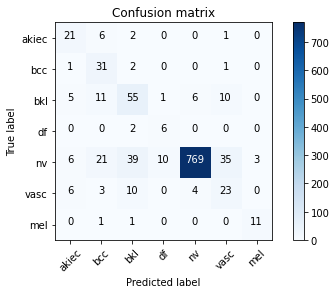

In [ ]:
### evaluation resnet 

model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

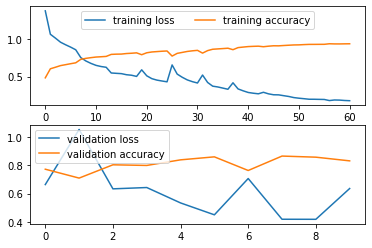

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.54      0.70      0.61        30
         bcc       0.42      0.89      0.57        35
         bkl       0.50      0.62      0.55        88
          df       0.35      0.75      0.48         8
          nv       0.99      0.87      0.93       883
        vasc       0.33      0.50      0.40        46
         mel       0.79      0.85      0.81        13

    accuracy                           0.83      1103
   macro avg       0.56      0.74      0.62      1103
weighted avg       0.88      0.83      0.85      1103



In [ ]:
!pip install scikit-plot

### Vgg model training 

In [ ]:
############ next model is the vgg
# resnet,vgg,densenet,inception,mobilenet
model_nameVgg = 'vgg'
# Initialize the model for this run
model_ft2, input_size2 = initialize_model(model_nameVgg, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelVgg = model_ft2.to(device)

In [ ]:
##### training Vgg

optimizer = optim.Adam(modelVgg.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelVgg, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelVgg, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 606], [train loss 1.50178], [train acc 0.40813]
[epoch 1], [iter 200 / 606], [train loss 1.33394], [train acc 0.49109]
[epoch 1], [iter 300 / 606], [train loss 1.25852], [train acc 0.52740]
[epoch 1], [iter 400 / 606], [train loss 1.23184], [train acc 0.54016]
[epoch 1], [iter 500 / 606], [train loss 1.19356], [train acc 0.55869]
[epoch 1], [iter 600 / 606], [train loss 1.15597], [train acc 0.57589]
------------------------------------------------------------
[epoch 1], [val loss 0.68959], [val acc 0.76827]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.68959], [val acc 0.76827]
*****************************************************
[epoch 2], [iter 100 / 606], [train loss 0.91816], [train acc 0.67906]
[epoch 2], [iter 200 / 606], [train loss 0.94567], [train acc 0.67172]
[epoch 2], [iter 300 / 606], [train loss 0.90741], [train acc 0.68677]
[epoch 2], [iter 400

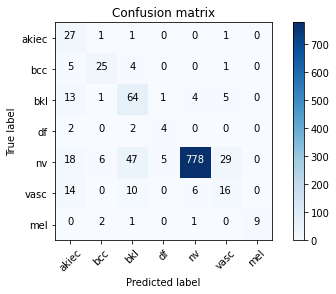

In [ ]:
### evaluation Vgg

modelVgg.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelVgg(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

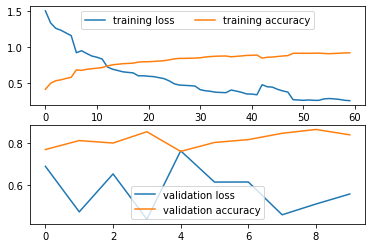

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.34      0.90      0.50        30
         bcc       0.71      0.71      0.71        35
         bkl       0.50      0.73      0.59        88
          df       0.40      0.50      0.44         8
          nv       0.99      0.88      0.93       883
        vasc       0.31      0.35      0.33        46
         mel       1.00      0.69      0.82        13

    accuracy                           0.84      1103
   macro avg       0.61      0.68      0.62      1103
weighted avg       0.89      0.84      0.85      1103



### Training Densnet 

In [ ]:
############ model densnet
# resnet,vgg,densenet,inception,mobilenet
model_nameDen = 'densenet'
# Initialize the model for this run
model_ft3, input_size3 = initialize_model(model_nameDen, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelDen = model_ft3.to(device)


###### training densnet 

optimizer = optim.Adam(modelDen.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelDen, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelDen, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 606], [train loss 1.13171], [train acc 0.58000]
[epoch 1], [iter 200 / 606], [train loss 1.00190], [train acc 0.63062]
[epoch 1], [iter 300 / 606], [train loss 0.89840], [train acc 0.66698]
[epoch 1], [iter 400 / 606], [train loss 0.83175], [train acc 0.69391]
[epoch 1], [iter 500 / 606], [train loss 0.78638], [train acc 0.71062]
[epoch 1], [iter 600 / 606], [train loss 0.75391], [train acc 0.72245]
------------------------------------------------------------
[epoch 1], [val loss 0.43288], [val acc 0.85679]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.43288], [val acc 0.85679]
*****************************************************
[epoch 2], [iter 100 / 606], [train loss 0.57729], [train acc 0.78906]
[epoch 2], [iter 200 / 606], [train loss 0.52080], [train acc 0.80703]
[epoch 2], [iter 300 / 606], [train loss 0.50181], [train acc 0.81302]
[epoch 2], [iter 400

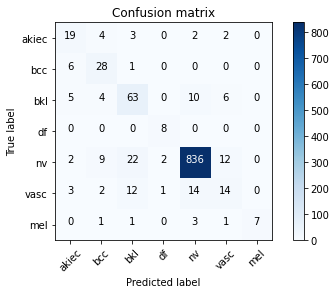

In [ ]:
### evaluation Densnet

modelDen.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelDen(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

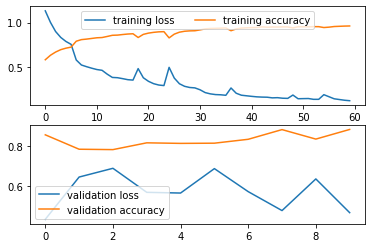

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.54      0.63      0.58        30
         bcc       0.58      0.80      0.67        35
         bkl       0.62      0.72      0.66        88
          df       0.73      1.00      0.84         8
          nv       0.97      0.95      0.96       883
        vasc       0.40      0.30      0.35        46
         mel       1.00      0.54      0.70        13

    accuracy                           0.88      1103
   macro avg       0.69      0.71      0.68      1103
weighted avg       0.89      0.88      0.88      1103



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 23 21:32:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    50W / 250W |  12325MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### Training inception

In [ ]:
######## model inception


train_transformI = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transformI = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])


# Define the training set using the table train_df and using our defined transitions (train_transform)
training_setI = HAM10000(df_trainOS, transform=train_transformI)
train_loaderI = DataLoader(training_setI, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_setI = HAM10000(df_val, transform=val_transformI)
val_loaderI = DataLoader(validation_setI, batch_size=32, shuffle=False, num_workers=4)

###### training inception 


In [ ]:
modelI

In [ ]:
model_nameI = 'inception'
# Initialize the model for this run
num_classes = 7
feature_extract = False
model_ft, input_size = initialize_model(model_nameI,num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelI = model_ft.to(device)


###### training densnet 

optimizer = optim.Adam(modelI.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderI, modelI, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loaderI, modelI, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 606], [train loss 1.19274], [train acc 0.56969]
[epoch 1], [iter 200 / 606], [train loss 1.03689], [train acc 0.63234]
[epoch 1], [iter 300 / 606], [train loss 0.94506], [train acc 0.66552]
[epoch 1], [iter 400 / 606], [train loss 0.89084], [train acc 0.68375]
[epoch 1], [iter 500 / 606], [train loss 0.83579], [train acc 0.70331]
[epoch 1], [iter 600 / 606], [train loss 0.79044], [train acc 0.71964]
------------------------------------------------------------
[epoch 1], [val loss 0.60570], [val acc 0.78536]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.60570], [val acc 0.78536]
*****************************************************
[epoch 2], [iter 100 / 606], [train loss 0.58619], [train acc 0.79781]
[epoch 2], [iter 200 / 606], [train loss 0.55146], [train acc 0.80781]
[epoch 2], [iter 300 / 606], [train loss 0.52131], [train acc 0.81688]
[epoch 2], [iter 400

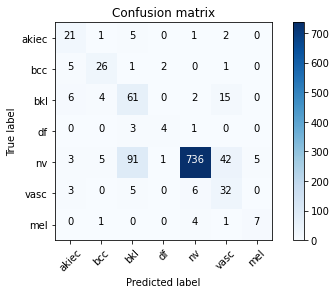

In [ ]:
modelI.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loaderI):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelI(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

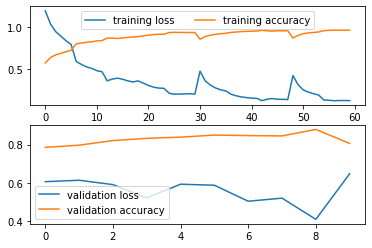

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.55      0.70      0.62        30
         bcc       0.70      0.74      0.72        35
         bkl       0.37      0.69      0.48        88
          df       0.57      0.50      0.53         8
          nv       0.98      0.83      0.90       883
        vasc       0.34      0.70      0.46        46
         mel       0.58      0.54      0.56        13

    accuracy                           0.80      1103
   macro avg       0.59      0.67      0.61      1103
weighted avg       0.88      0.80      0.83      1103



### Training mobilenet 


In [ ]:
# model mobilenet
model_nameM = 'mobilenet'
# Initialize the model for this run
model_ft5, input_size5 = initialize_model(model_nameM, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelM = model_ft5.to(device)


###### training mobilenet

optimizer = optim.Adam(modelM.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelM, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelM, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')


[epoch 1], [iter 100 / 606], [train loss 1.32948], [train acc 0.59188]
[epoch 1], [iter 200 / 606], [train loss 1.00071], [train acc 0.67047]
[epoch 1], [iter 300 / 606], [train loss 0.84628], [train acc 0.71677]
[epoch 1], [iter 400 / 606], [train loss 0.75180], [train acc 0.74500]
[epoch 1], [iter 500 / 606], [train loss 0.69169], [train acc 0.76287]
[epoch 1], [iter 600 / 606], [train loss 0.63524], [train acc 0.78078]
------------------------------------------------------------
[epoch 1], [val loss 0.45261], [val acc 0.84810]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.45261], [val acc 0.84810]
*****************************************************
[epoch 2], [iter 100 / 606], [train loss 0.31700], [train acc 0.89625]
[epoch 2], [iter 200 / 606], [train loss 0.29045], [train acc 0.90406]
[epoch 2], [iter 300 / 606], [train loss 0.28319], [train acc 0.90396]
[epoch 2], [iter 400

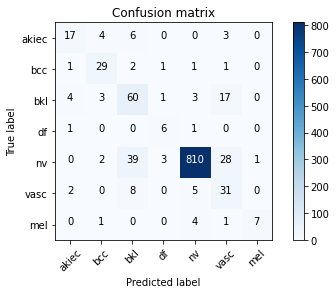

In [ ]:
modelM.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelM(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

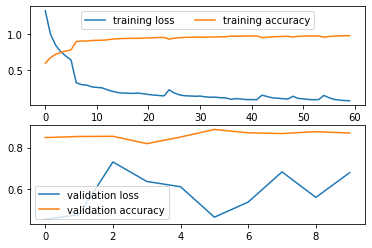

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.68      0.57      0.62        30
         bcc       0.74      0.83      0.78        35
         bkl       0.52      0.68      0.59        88
          df       0.55      0.75      0.63         8
          nv       0.98      0.92      0.95       883
        vasc       0.38      0.67      0.49        46
         mel       0.88      0.54      0.67        13

    accuracy                           0.87      1103
   macro avg       0.68      0.71      0.68      1103
weighted avg       0.90      0.87      0.88      1103



### balancing via balanced sampling  with replacement 

In [ ]:
#df_val = df_val.reset_index()

In [ ]:
df_trainBalanced = df_train.reset_index()
df_trainBalanced.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,duplicates,train_or_val
0,10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,vidir_modern,./HAM10000_images_part_1/ISIC_0025276.jpg,Benign keratosis-like lesions,2,unduplicated,train
1,15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,vidir_modern,./HAM10000_images_part_2/ISIC_0031326.jpg,Benign keratosis-like lesions,2,unduplicated,train
2,20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,vidir_modern,./HAM10000_images_part_2/ISIC_0032343.jpg,Benign keratosis-like lesions,2,unduplicated,train
3,33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0024981.jpg,Benign keratosis-like lesions,2,unduplicated,train
4,34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,rosendahl,./HAM10000_images_part_1/ISIC_0027815.jpg,Benign keratosis-like lesions,2,unduplicated,train


In [ ]:
#df_trainBalanced = df_undup[df_undup['train_or_val'] == 'train'] # df_original
print(len(df_trainBalanced))

4411


In [ ]:
class_sample_count = np.array(
    [len(np.where(df_trainBalanced.cell_type == t)[0]) for t in np.unique(df_trainBalanced.cell_type)])

weight = 1./class_sample_count
weight




array([0.00826446, 0.00714286, 0.00284091, 0.03225806, 0.00028313,
       0.00543478, 0.01960784])

In [ ]:

samples_weight=np.array([weight[t] for t in df_trainBalanced.cell_type_idx])
print(samples_weight)
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()

sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

[0.00284091 0.00284091 0.00284091 ... 0.00826446 0.00826446 0.00826446]


In [ ]:
samples_weigth *10

tensor([0.0284, 0.0284, 0.0284,  ..., 0.0826, 0.0826, 0.0826],
       dtype=torch.float64)

In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_setBalanced = HAM10000(df_trainBalanced , transform=train_transform)
train_loaderBalanced = DataLoader(training_setBalanced,batch_size=32,  sampler=sampler, num_workers=4)
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
sampler.num_samples

4411

In [ ]:
#### repetining the resnet50 model with the randomSAMPLIER 

### Resnet via Balancedsampling

In [ ]:
# resnet,vgg,densenet,inception,mobilenet
model_name = 'resnet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderBalanced, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 138], [train loss 1.31922], [train acc 0.51625]
------------------------------------------------------------
[epoch 1], [val loss 3.57592], [val acc 0.24923]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 3.57592], [val acc 0.24923]
*****************************************************
[epoch 2], [iter 100 / 138], [train loss 1.01746], [train acc 0.61469]
------------------------------------------------------------
[epoch 2], [val loss 1.21226], [val acc 0.60821]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 1.21226], [val acc 0.60821]
*****************************************************
[epoch 3], [iter 100 / 138], [train loss 0.91149], [train acc 0.66563]
------------------------------------------------------------
[epoch 3], [val loss 0.79150], [val acc 0.75

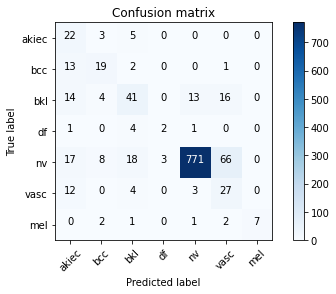

In [ ]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

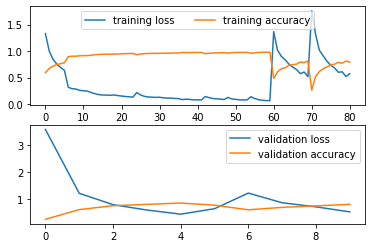

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.28      0.73      0.40        30
         bcc       0.53      0.54      0.54        35
         bkl       0.55      0.47      0.50        88
          df       0.40      0.25      0.31         8
          nv       0.98      0.87      0.92       883
        vasc       0.24      0.59      0.34        46
         mel       1.00      0.54      0.70        13

    accuracy                           0.81      1103
   macro avg       0.57      0.57      0.53      1103
weighted avg       0.87      0.81      0.83      1103



### VGG

In [ ]:
############ next model is the vgg
# resnet,vgg,densenet,inception,mobilenet
model_nameVgg = 'vgg'
# Initialize the model for this run
model_ft2, input_size2 = initialize_model(model_nameVgg, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelVgg = model_ft2.to(device)

In [ ]:
optimizer = optim.Adam(modelVgg.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)


epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderBalanced, modelVgg, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelVgg, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 138], [train loss 1.42764], [train acc 0.45813]
------------------------------------------------------------
[epoch 1], [val loss 0.76017], [val acc 0.71851]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.76017], [val acc 0.71851]
*****************************************************
[epoch 2], [iter 100 / 138], [train loss 1.04923], [train acc 0.62094]
------------------------------------------------------------
[epoch 2], [val loss 0.76384], [val acc 0.71661]
------------------------------------------------------------
[epoch 3], [iter 100 / 138], [train loss 0.87971], [train acc 0.66469]
------------------------------------------------------------
[epoch 3], [val loss 0.83148], [val acc 0.73435]
------------------------------------------------------------
*****************************************************
best record: [epoch 3], [val loss 0.83148], [val a

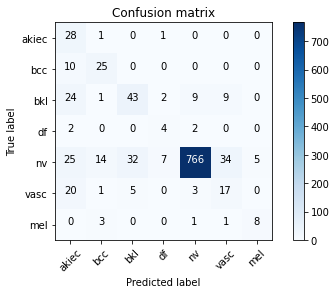

In [ ]:
modelVgg.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelVgg(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

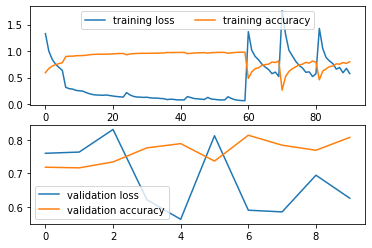

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.26      0.93      0.40        30
         bcc       0.56      0.71      0.63        35
         bkl       0.54      0.49      0.51        88
          df       0.29      0.50      0.36         8
          nv       0.98      0.87      0.92       883
        vasc       0.28      0.37      0.32        46
         mel       0.62      0.62      0.62        13

    accuracy                           0.81      1103
   macro avg       0.50      0.64      0.54      1103
weighted avg       0.87      0.81      0.83      1103



### DEnsnet

In [ ]:
model_nameDen = 'densenet'
# Initialize the model for this run
model_ft3, input_size3 = initialize_model(model_nameDen, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelDen = model_ft3.to(device)


###### training densnet 

optimizer = optim.Adam(modelDen.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderBalanced, modelDen, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelDen, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 138], [train loss 1.16307], [train acc 0.57281]
------------------------------------------------------------
[epoch 1], [val loss 0.73146], [val acc 0.75857]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.73146], [val acc 0.75857]
*****************************************************
[epoch 2], [iter 100 / 138], [train loss 0.73502], [train acc 0.73250]
------------------------------------------------------------
[epoch 2], [val loss 0.57182], [val acc 0.80155]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.57182], [val acc 0.80155]
*****************************************************
[epoch 3], [iter 100 / 138], [train loss 0.63069], [train acc 0.77281]
------------------------------------------------------------
[epoch 3], [val loss 0.88201], [val acc 0.73

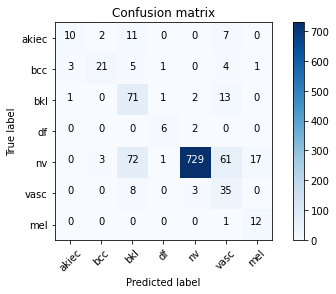

In [ ]:
modelDen.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelDen(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

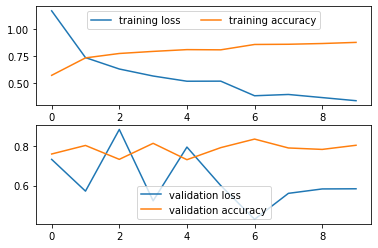

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.71      0.33      0.45        30
         bcc       0.81      0.60      0.69        35
         bkl       0.43      0.81      0.56        88
          df       0.67      0.75      0.71         8
          nv       0.99      0.83      0.90       883
        vasc       0.29      0.76      0.42        46
         mel       0.40      0.92      0.56        13

    accuracy                           0.80      1103
   macro avg       0.61      0.71      0.61      1103
weighted avg       0.89      0.80      0.83      1103



### Inception

In [ ]:

model_nameI = 'inception'
# Initialize the model for this run
num_classes = 7
feature_extract = False
model_ft, input_size = initialize_model(model_nameI,num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelI = model_ft.to(device)


###### training densnet 

optimizer = optim.Adam(modelI.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderBalanced, modelI, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loaderI, modelI, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 138], [train loss 1.18465], [train acc 0.59344]
------------------------------------------------------------
[epoch 1], [val loss 0.66781], [val acc 0.73167]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.66781], [val acc 0.73167]
*****************************************************
[epoch 2], [iter 100 / 138], [train loss 0.84212], [train acc 0.69812]
------------------------------------------------------------
[epoch 2], [val loss 1.14048], [val acc 0.70095]
------------------------------------------------------------
[epoch 3], [iter 100 / 138], [train loss 0.67464], [train acc 0.76687]
------------------------------------------------------------
[epoch 3], [val loss 1.30759], [val acc 0.55464]
------------------------------------------------------------
[epoch 4], [iter 100 / 138], [train loss 0.61411], [train acc 0.78531]
---------------------------------

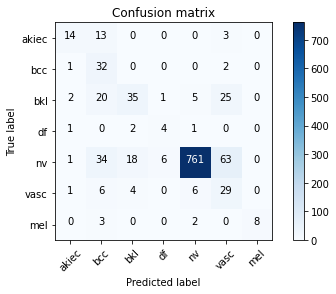

In [ ]:
modelI.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loaderI):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelI(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

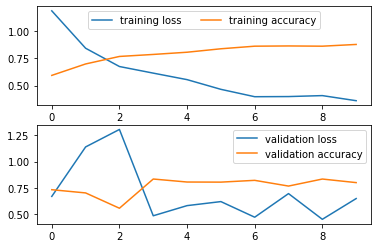

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.70      0.47      0.56        30
         bcc       0.30      0.91      0.45        35
         bkl       0.59      0.40      0.48        88
          df       0.36      0.50      0.42         8
          nv       0.98      0.86      0.92       883
        vasc       0.24      0.63      0.35        46
         mel       1.00      0.62      0.76        13

    accuracy                           0.80      1103
   macro avg       0.60      0.63      0.56      1103
weighted avg       0.89      0.80      0.83      1103



### Mobilenet

In [ ]:
# model mobilenet
model_nameM = 'mobilenet'
# Initialize the model for this run
model_ft5, input_size5 = initialize_model(model_nameM, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelM = model_ft5.to(device)


###### training mobilenet

optimizer = optim.Adam(modelM.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderBalanced, modelM, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelM, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')


[epoch 1], [iter 100 / 138], [train loss 1.29546], [train acc 0.59156]
------------------------------------------------------------
[epoch 1], [val loss 0.95831], [val acc 0.72452]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.95831], [val acc 0.72452]
*****************************************************
[epoch 2], [iter 100 / 138], [train loss 0.62834], [train acc 0.77094]
------------------------------------------------------------
[epoch 2], [val loss 1.32813], [val acc 0.58988]
------------------------------------------------------------
[epoch 3], [iter 100 / 138], [train loss 0.46243], [train acc 0.83531]
------------------------------------------------------------
[epoch 3], [val loss 1.28121], [val acc 0.54190]
------------------------------------------------------------
[epoch 4], [iter 100 / 138], [train loss 0.35621], [train acc 0.87187]
---------------------------------

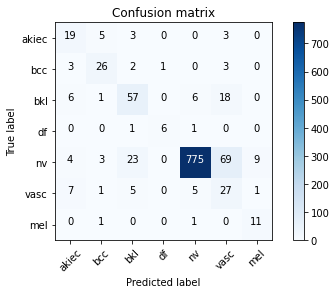

In [ ]:
modelM.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelM(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

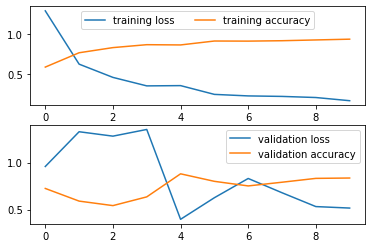

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.49      0.63      0.55        30
         bcc       0.70      0.74      0.72        35
         bkl       0.63      0.65      0.64        88
          df       0.86      0.75      0.80         8
          nv       0.98      0.88      0.93       883
        vasc       0.23      0.59      0.33        46
         mel       0.52      0.85      0.65        13

    accuracy                           0.83      1103
   macro avg       0.63      0.73      0.66      1103
weighted avg       0.89      0.83      0.86      1103



### balancing via loss function 

In [ ]:
import torch.nn.functional as F
import torch
import torch.nn as nn

class WeighedLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight, reduction='none'):
        super(WeighedLoss, self).__init__(weight,reduction=reduction)
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights
   
    def forward(self, input, target): 
        ce_loss = F.cross_entropy(input, target,weight=self.weight, size_average=True)

        return ce_loss


In [ ]:
df_train.dx.value_counts()

nv       3532
bkl       352
mel       184
bcc       140
akiec     121
vasc       51
df         31
Name: dx, dtype: int64

In [ ]:
import math 
num_classes =7

labels = sorted(df_train.cell_type_idx.unique())
classWeight = []
max =0 
for i in labels:
  classLen = len(df_train.loc[df_train.cell_type_idx==i])
  classWeight.append(classLen)
  if classLen >max:
    max =classLen 
  
classW =[(classWeight[4]/x) for x in classWeight]
classW

[29.1900826446281,
 25.228571428571428,
 10.034090909090908,
 113.93548387096774,
 1.0,
 19.195652173913043,
 69.25490196078431]

In [ ]:
df_train  = df_train.reset_index()#df_original[(df_original['train_or_val'] == 'train')].reset_index()
df_val =df_val.reset_index(drop=True)
labels = sorted(df_train.cell_type_idx.unique())
classWeight = []
max =0
for i in labels:
  classLen = len(df_train.loc[df_train.cell_type_idx==i])
  classWeight.append(classLen)
  if classLen >max:
    max =classLen 

classW =[(max/x) for x in classWeight]
classW= torch.tensor(classW, dtype=torch.float).to(device)
print(classW)

tensor([ 29.1901,  25.2286,  10.0341, 113.9355,   1.0000,  19.1957,  69.2549],
       device='cuda:0')


In [ ]:

normedWeights = [1 - (x / sum(classWeight)) for x in classWeight]
normedWeights = torch.FloatTensor(normedWeights).to(device)
normedWeights

tensor([0.9726, 0.9683, 0.9202, 0.9929, 0.1993, 0.9583, 0.9884],
       device='cuda:0')

In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set,batch_size=32,   num_workers=1)
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=1)

### Resnet 

In [ ]:
# resnet,vgg,densenet,inception,mobilenet
model_name = 'resnet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = WeighedLoss(weight=classW).to(device)
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 138], [train loss 2.01808], [train acc 0.37281]
------------------------------------------------------------
[epoch 1], [val loss 1.72667], [val acc 0.58232]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 1.72667], [val acc 0.58232]
*****************************************************
[epoch 2], [iter 100 / 138], [train loss 1.74562], [train acc 0.49406]
------------------------------------------------------------
[epoch 2], [val loss 1.66074], [val acc 0.46054]
------------------------------------------------------------
[epoch 3], [iter 100 / 138], [train loss 1.60423], [train acc 0.50562]
------------------------------------------------------------
[epoch 3], [val loss 1.64469], [val acc 0.72643]
------------------------------------------------------------
*****************************************************
best record: [epoch 3], [val loss 1.64469], [val a

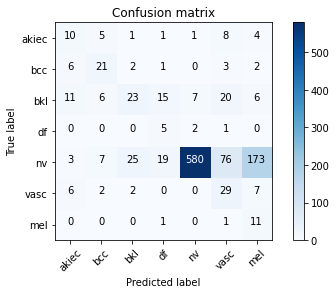

In [ ]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

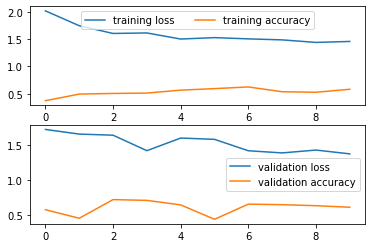

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.28      0.33      0.30        30
         bcc       0.51      0.60      0.55        35
         bkl       0.43      0.26      0.33        88
          df       0.12      0.62      0.20         8
          nv       0.98      0.66      0.79       883
        vasc       0.21      0.63      0.32        46
         mel       0.05      0.85      0.10        13

    accuracy                           0.62      1103
   macro avg       0.37      0.56      0.37      1103
weighted avg       0.86      0.62      0.70      1103



### VGG

In [ ]:
# resnet,vgg,densenet,inception,mobilenet
num_classes =7
feature_extract = False
model_nameVgg = 'vgg'
# Initialize the model for this run
model_ft2, input_size2 = initialize_model(model_nameVgg, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelVgg = model_ft2.to(device)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [ ]:
optimizer = optim.Adam(modelVgg.parameters(), lr=1e-3)

criterion = WeighedLoss(weight=classW).to(device)
epoch = 10
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelVgg,criterion,  optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelVgg, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 138], [train loss 2.05028], [train acc 0.32219]
------------------------------------------------------------
[epoch 1], [val loss 1.74364], [val acc 0.71024]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 1.74364], [val acc 0.71024]
*****************************************************
[epoch 2], [iter 100 / 138], [train loss 1.93192], [train acc 0.51438]
------------------------------------------------------------
[epoch 2], [val loss 2.01703], [val acc 0.72643]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 2.01703], [val acc 0.72643]
*****************************************************
[epoch 3], [iter 100 / 138], [train loss 1.98782], [train acc 0.43375]
------------------------------------------------------------
[epoch 3], [val loss 1.71234], [val acc 0.72

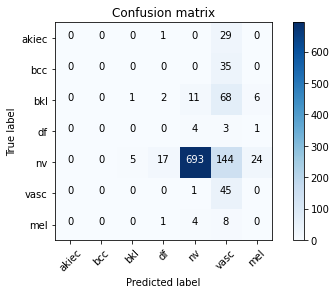

In [ ]:
modelVgg.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelVgg(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

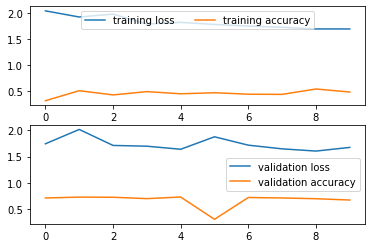

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        30
         bcc       0.00      0.00      0.00        35
         bkl       0.17      0.01      0.02        88
          df       0.00      0.00      0.00         8
          nv       0.97      0.78      0.87       883
        vasc       0.14      0.98      0.24        46
         mel       0.00      0.00      0.00        13

    accuracy                           0.67      1103
   macro avg       0.18      0.25      0.16      1103
weighted avg       0.80      0.67      0.71      1103



### DEnsenet

In [ ]:
model_nameDen = 'densenet'
# Initialize the model for this run
model_ft3, input_size3 = initialize_model(model_nameDen, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelDen = model_ft3.to(device)


###### training densnet 
criterion = WeighedLoss(weight=classW).to(device)
optimizer = optim.Adam(modelDen.parameters(), lr=1e-3)
total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelDen, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelDen, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 138], [train loss 1.71705], [train acc 0.50156]
------------------------------------------------------------
[epoch 1], [val loss 8.63972], [val acc 0.09655]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 8.63972], [val acc 0.09655]
*****************************************************
[epoch 2], [iter 100 / 138], [train loss 1.64698], [train acc 0.56531]
------------------------------------------------------------
[epoch 2], [val loss 1.63732], [val acc 0.53625]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 1.63732], [val acc 0.53625]
*****************************************************
[epoch 3], [iter 100 / 138], [train loss 1.56042], [train acc 0.54688]
------------------------------------------------------------
[epoch 3], [val loss 2.91947], [val acc 0.69

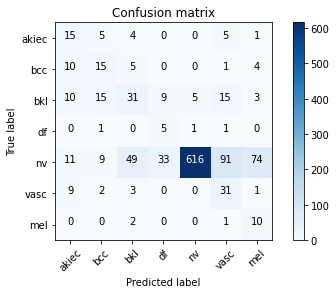

In [ ]:
modelDen.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelDen(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

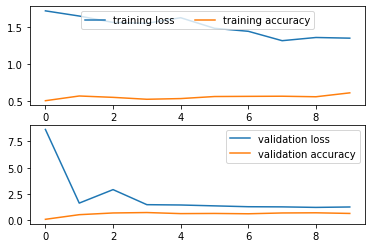

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.27      0.50      0.35        30
         bcc       0.32      0.43      0.37        35
         bkl       0.33      0.35      0.34        88
          df       0.11      0.62      0.18         8
          nv       0.99      0.70      0.82       883
        vasc       0.21      0.67      0.32        46
         mel       0.11      0.77      0.19        13

    accuracy                           0.66      1103
   macro avg       0.33      0.58      0.37      1103
weighted avg       0.85      0.66      0.72      1103



### Intercept

In [ ]:
model_nameI = 'inception'
# Initialize the model for this run
num_classes = 7
feature_extract = False
model_ft3, input_size = initialize_model(model_nameI,num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelI = model_ft3.to(device)


###### training densnet 

optimizer = optim.Adam(modelI.parameters(), lr=1e-3)
criterion = WeighedLoss(weight=classW).to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelI, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelI, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 138], [train loss 1.92690], [train acc 0.36219]
------------------------------------------------------------
[epoch 1], [val loss 1.70163], [val acc 0.79083]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 1.70163], [val acc 0.79083]
*****************************************************
[epoch 2], [iter 100 / 138], [train loss 2.03810], [train acc 0.57563]
------------------------------------------------------------
[epoch 2], [val loss 4.56217], [val acc 0.71304]
------------------------------------------------------------
[epoch 3], [iter 100 / 138], [train loss 2.02492], [train acc 0.75531]
------------------------------------------------------------
[epoch 3], [val loss 1.93497], [val acc 0.80167]
------------------------------------------------------------
*****************************************************
best record: [epoch 3], [val loss 1.93497], [val a

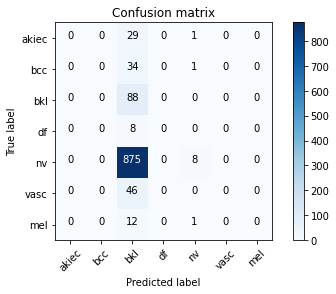

In [ ]:
modelI.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelI(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

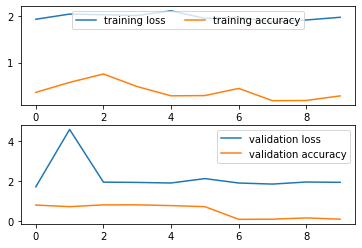

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        30
         bcc       0.00      0.00      0.00        35
         bkl       0.08      1.00      0.15        88
          df       0.00      0.00      0.00         8
          nv       0.73      0.01      0.02       883
        vasc       0.00      0.00      0.00        46
         mel       0.00      0.00      0.00        13

    accuracy                           0.09      1103
   macro avg       0.12      0.14      0.02      1103
weighted avg       0.59      0.09      0.03      1103



### Mobilenet

In [ ]:
# model mobilenet
model_nameM = 'mobilenet'
# Initialize the model for this run
model_ft5, input_size5 = initialize_model(model_nameM, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelM = model_ft5.to(device)


###### training mobilenet

optimizer = optim.Adam(modelM.parameters(), lr=1e-3)
criterion = WeighedLoss(weight=classW).to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelM, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelM, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

RuntimeError: ignored

In [ ]:
modelM.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelM(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)